In [15]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import ff

def interpolate_dataset(data, extend=0, poly_order=1):
    """
    Interpolate a dataset of (x,y) pairs, where x are integers, using polynomial interpolation.
    
    Args:
        data: List of (x,y) tuples where x are integers
        extend: Number of points to extend beyond max(x)
        poly_order: Order of the polynomial to use for interpolation (1=linear, 2=quadratic, etc.)
                    Will automatically reduce order if not enough points are available
    
    Returns:
        List of (x,y) tuples with interpolated and extended values
    """
    # Sort data by x values
    sorted_data = sorted(data, key=lambda point: point[0])
    
    # Extract x and y values
    x_values = [point[0] for point in sorted_data]
    y_values = [point[1] for point in sorted_data]
    
    # Find min and max x values
    min_x = min(x_values)
    max_x = max(x_values)
    
    # Create a dictionary from original data for easy lookup
    data_dict = {x: y for x, y in sorted_data}
    
    # Ensure we have enough points for the polynomial order
    actual_poly_order = min(poly_order, len(sorted_data) - 1)
    if actual_poly_order != poly_order:
        print(f"Warning: Reduced polynomial order from {poly_order} to {actual_poly_order} due to insufficient data points")
    
    result = []
    
    # If we have enough points for polynomial interpolation
    if len(sorted_data) > 1:
        if actual_poly_order == 1:
            # Linear interpolation (original method)
            for x in range(min_x, max_x + 1):
                if x in data_dict:
                    result.append((x, data_dict[x]))
                else:
                    # Find closest points before and after x
                    left_idx = 0
                    while left_idx < len(x_values) - 1 and x_values[left_idx + 1] <= x:
                        left_idx += 1
                    
                    right_idx = len(x_values) - 1
                    while right_idx > 0 and x_values[right_idx - 1] >= x:
                        right_idx -= 1
                    
                    # Interpolate y value
                    x1, y1 = x_values[left_idx], y_values[left_idx]
                    x2, y2 = x_values[right_idx], y_values[right_idx]
                    
                    y = y1 + (x - x1) * (y2 - y1) / (x2 - x1)
                    result.append((x, y))
        else:
            # Polynomial interpolation
            coeffs = np.polyfit(x_values, y_values, actual_poly_order)
            
            # Interpolate for all integer points
            for x in range(min_x, max_x + 1):
                if x in data_dict:
                    # Use original data point if available
                    result.append((x, data_dict[x]))
                else:
                    # Use polynomial to interpolate
                    y = np.polyval(coeffs, x)
                    result.append((x, y))
    else:
        # Just one point, can't interpolate
        result = sorted_data.copy()
    
    # Extend beyond max_x if requested (always using linear extension)
    if extend > 0 and len(x_values) >= 2:
        # Get the last two points to determine the slope for extension
        second_to_last_x = x_values[-2]
        second_to_last_y = y_values[-2]
        last_x = x_values[-1]
        last_y = y_values[-1]
        
        # Calculate slope
        slope = (last_y - second_to_last_y) / (last_x - second_to_last_x)
        
        # Add extended points
        for i in range(1, extend + 1):
            x = max_x + i
            y = last_y + slope * i
            result.append((x, y))
    
    return result


# Path to the transmitted power file
file_path = '../logs/central-dep-concluded-double-v2/transmitted_power.txt'

# Initialize empty lists for wavelengths and transmitted power values
wavelengths = []
transmitted_power = []

# Read the file and extract the values
with open(file_path, 'r') as f:
    for line in f:
        # Split the line by colon and extract values
        parts = line.strip().split(': ')
        if len(parts) == 2:
            wavelength = float(parts[0])
            power = float(parts[1])
            wavelengths.append(wavelength)
            transmitted_power.append(power)

# Convert lists to numpy arrays for easier manipulation
wavelengths = np.round(np.array(wavelengths)*1000)
transmitted_power = np.array(transmitted_power)

# Print the first few values to verify
print(f"Loaded {len(wavelengths)} data points")
print("First 5 wavelengths:", wavelengths[:5])
print("First 5 transmitted power values:", transmitted_power[:5])
wavelengths = torch.tensor(wavelengths)

data = [(int(wavelengths[i].item()), transmitted_power[i]) for i in range(len(wavelengths))]
print(data)
interpolated_data = interpolate_dataset(data, extend=0, poly_order=1)
interpolated_ppw = torch.tensor([i[1] for i in interpolated_data])
wavelengths = torch.linspace(.350, 3, 2651)
print(len(wavelengths),len(interpolated_ppw))
bandgaps = [.5, .6, .61, .62, .63, .64, .65, .66, .67, .68, .69, .7, .71, .72, .726, .8, .9, 1]

FOMs = []

for bandgap in bandgaps:
    FOMs.append(ff.power_ratio(wavelengths, torch.tensor(interpolated_ppw), ff.T_e, bandgap).item())
    print(f"Bandgap: {bandgap}, FOM: {FOMs[-1]}")

Loaded 531 data points
First 5 wavelengths: [350. 355. 360. 365. 370.]
First 5 transmitted power values: [0.55704925 0.53262582 0.55173869 0.61581208 0.74031547]
[(350, np.float64(0.557049250082932)), (355, np.float64(0.5326258160496036)), (360, np.float64(0.5517386909704203)), (365, np.float64(0.6158120762579278)), (370, np.float64(0.7403154688878706)), (375, np.float64(0.8465996686048353)), (380, np.float64(0.919082166377995)), (385, np.float64(0.9467914931936015)), (390, np.float64(0.9078852966171594)), (395, np.float64(0.8209913549418624)), (400, np.float64(0.7323075307767493)), (405, np.float64(0.6612240410264474)), (410, np.float64(0.612408694803468)), (415, np.float64(0.5830266885665749)), (420, np.float64(0.5687774271906141)), (425, np.float64(0.567922065461614)), (430, np.float64(0.5812331158934315)), (435, np.float64(0.6100059685423926)), (440, np.float64(0.6544514837053415)), (445, np.float64(0.7123774450006828)), (450, np.float64(0.7772075648768951)), (455, np.float64(0.839

/tmp/ipykernel_237572/181393424.py:139: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  FOMs.append(ff.power_ratio(wavelengths, torch.tensor(interpolated_ppw), ff.T_e, bandgap).item())
/home/rliacobacci/tpv-shaping/trials/ff.py:377: RuntimeWarning: overflow encountered in exp
  return (2*c) / ((np.exp((h*c)/(k_B*T*lambda_i*1e-6))-1)*lambda_i**4)*1e8


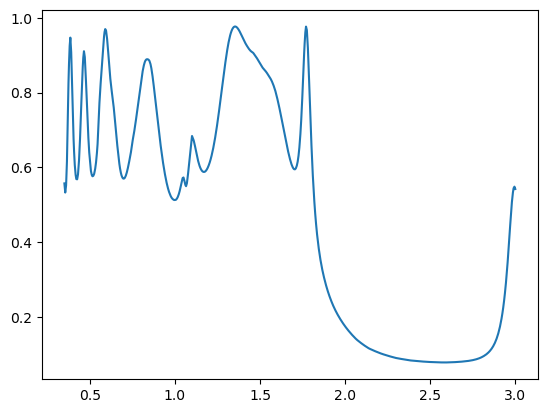

In [17]:
plt.plot(wavelengths.numpy(), interpolated_ppw)

In [2]:
import torch
import numpy as np
def interpolate_dataset(data, extend=0, poly_order=1):
    """
    Interpolate a dataset of (x,y) pairs, where x are integers, using polynomial interpolation.
    
    Args:
        data: List of (x,y) tuples where x are integers
        extend: Number of points to extend beyond max(x)
        poly_order: Order of the polynomial to use for interpolation (1=linear, 2=quadratic, etc.)
                    Will automatically reduce order if not enough points are available
    
    Returns:
        List of (x,y) tuples with interpolated and extended values
    """
    # Sort data by x values
    sorted_data = sorted(data, key=lambda point: point[0])
    
    # Extract x and y values
    x_values = [point[0] for point in sorted_data]
    y_values = [point[1] for point in sorted_data]
    
    # Find min and max x values
    min_x = min(x_values)
    max_x = max(x_values)
    
    # Create a dictionary from original data for easy lookup
    data_dict = {x: y for x, y in sorted_data}
    
    # Ensure we have enough points for the polynomial order
    actual_poly_order = min(poly_order, len(sorted_data) - 1)
    if actual_poly_order != poly_order:
        print(f"Warning: Reduced polynomial order from {poly_order} to {actual_poly_order} due to insufficient data points")
    
    result = []
    
    # If we have enough points for polynomial interpolation
    if len(sorted_data) > 1:
        if actual_poly_order == 1:
            # Linear interpolation (original method)
            for x in range(min_x, max_x + 1):
                if x in data_dict:
                    result.append((x, data_dict[x]))
                else:
                    # Find closest points before and after x
                    left_idx = 0
                    while left_idx < len(x_values) - 1 and x_values[left_idx + 1] <= x:
                        left_idx += 1
                    
                    right_idx = len(x_values) - 1
                    while right_idx > 0 and x_values[right_idx - 1] >= x:
                        right_idx -= 1
                    
                    # Interpolate y value
                    x1, y1 = x_values[left_idx], y_values[left_idx]
                    x2, y2 = x_values[right_idx], y_values[right_idx]
                    
                    y = y1 + (x - x1) * (y2 - y1) / (x2 - x1)
                    result.append((x, y))
        else:
            # Polynomial interpolation
            coeffs = np.polyfit(x_values, y_values, actual_poly_order)
            
            # Interpolate for all integer points
            for x in range(min_x, max_x + 1):
                if x in data_dict:
                    # Use original data point if available
                    result.append((x, data_dict[x]))
                else:
                    # Use polynomial to interpolate
                    y = np.polyval(coeffs, x)
                    result.append((x, y))
    else:
        # Just one point, can't interpolate
        result = sorted_data.copy()
    
    # Extend beyond max_x if requested (always using linear extension)
    if extend > 0 and len(x_values) >= 2:
        # Get the last two points to determine the slope for extension
        second_to_last_x = x_values[-2]
        second_to_last_y = y_values[-2]
        last_x = x_values[-1]
        last_y = y_values[-1]
        
        # Calculate slope
        slope = (last_y - second_to_last_y) / (last_x - second_to_last_x)
        
        # Add extended points
        for i in range(1, extend + 1):
            x = max_x + i
            y = last_y + slope * i
            result.append((x, y))
    
    return result

tensor(0.6293, grad_fn=<DivBackward0>)
tensor(0.6328)


/tmp/ipykernel_183260/438856250.py:36: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  interpolated_ppw+=grad


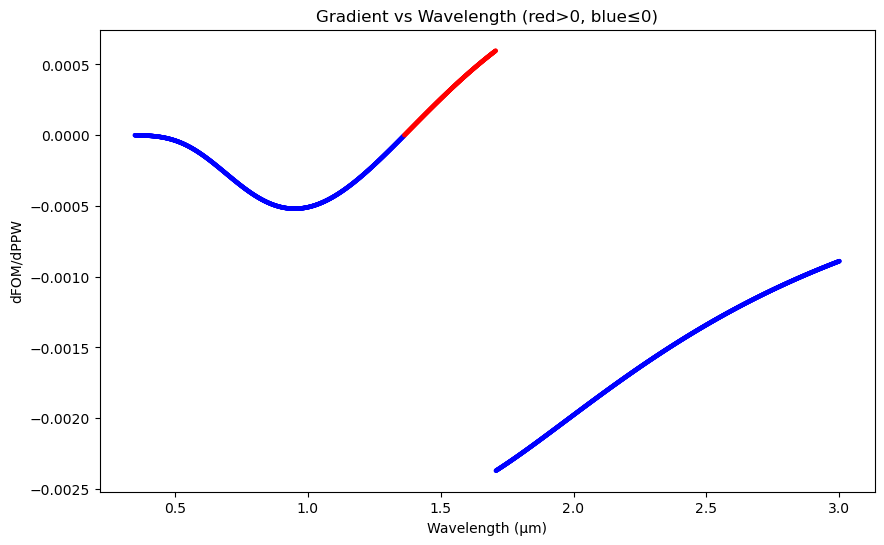

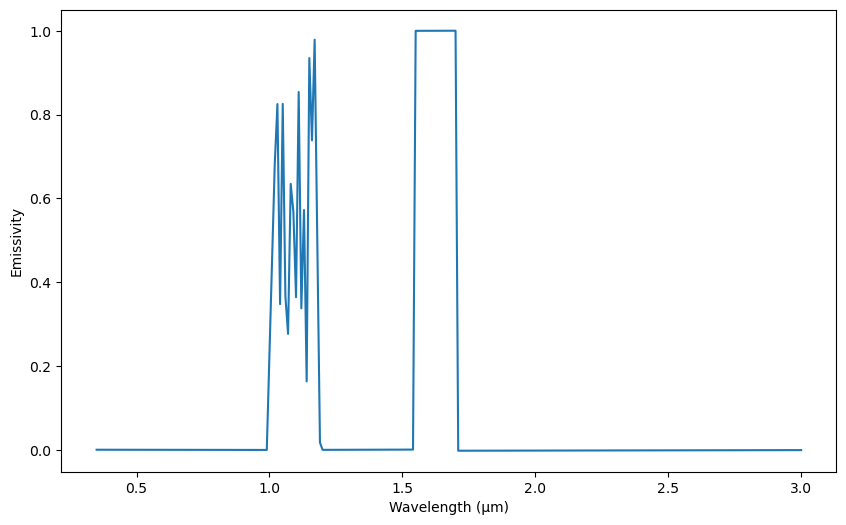

In [61]:
import torch
import ff
import matplotlib.pyplot as plt    # moved here

wavelengths = torch.linspace(.35, 3, 2651)
exclude_wavelengths = [.5, 1]
jump = 10

ems = []
indices_used = []
for i_wl, wl in enumerate(wavelengths):
    if wl.item() in exclude_wavelengths or i_wl % jump != 0:
        continue
    if 1.55 < wl < 1.708:
        ems.append(1)
    elif 1 < wl < 1.2:
        ems.append(np.random.rand())
    else:
        ems.append(0)
    indices_used.append(i_wl)

data = [(indices_used[i], ems[i]) for i in range(len(indices_used))]
interpolated_data = interpolate_dataset(data, extend=0, poly_order=1)
interpolated_ppw = torch.tensor([i[1] for i in interpolated_data], requires_grad=True)

# compute FOM and backprop
x = ff.power_ratio(wavelengths, interpolated_ppw, ff.T_e, .726)
x.backward()
print(x)

# grab gradient & wavelengths as NumPy
grad = interpolated_ppw.grad.detach().cpu().numpy()
wl   = wavelengths.cpu().numpy()

with torch.no_grad():
    interpolated_ppw+=grad
x = ff.power_ratio(wavelengths, interpolated_ppw, ff.T_e, .726)
print(x)

# colour‐coded scatter: red where grad>0 else blue
plt.figure(figsize=(10,6))
colors = ['r' if g > 0 else 'b' for g in grad]
plt.scatter(wl, grad, c=colors, s=5)
plt.xlabel('Wavelength (μm)')
plt.ylabel('dFOM/dPPW')
plt.title('Gradient vs Wavelength (red>0, blue≤0)')
plt.show()

# plot emissivity if you still want the grayscale line
plt.figure(figsize=(10,6))
plt.plot(wl, interpolated_ppw.detach().cpu().numpy())
plt.xlabel('Wavelength (μm)')
plt.ylabel('Emissivity')
plt.show()


/tmp/ipykernel_6224/50099063.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  first = torch.load(pt_files[0])
/tmp/ipykernel_6224/50099063.py:26: FutureWarning: You are 

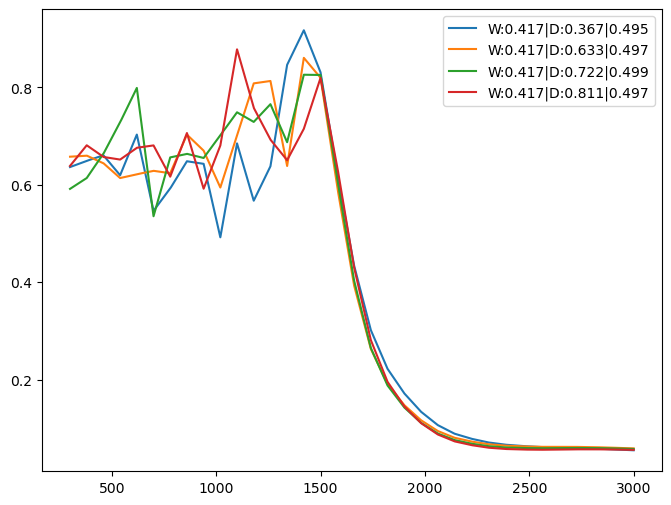

In [33]:
# %%
import torch
import matplotlib.pyplot as plt
from pathlib import Path
import ff

# 1. Point to your folder containing the .pt files
data_dir = Path('.')  # change if needed

# 2. Find all files matching the pattern
pt_files = sorted(data_dir.glob('*_cut_emission.pt'))

# 3. (Optional) if you saved wavelengths alongside emissivities, load from first file
first = torch.load(pt_files[0])
if isinstance(first, dict) and 'wavelengths' in first:
    wavelengths = first['wavelengths']
else:
    # fallback: just use a range index
    # you can replace this with your actual wavelengths tensor
    sample = first['emissivity'] if isinstance(first, dict) else first
    wavelengths = torch.arange(sample.numel())

# 4. Plot all emissivity profiles
plt.figure(figsize=(8,6))
for f in pt_files:
    data = torch.load(f)
    # unpack emissivity tensor
    if isinstance(data, dict):
        emissivity = data.get('emissivity', next(iter(data.values())))
    else:
        emissivity = data
    opt = ff.power_ratio((wavelengths[:2651]+300)/1000, emissivity[:2651], ff.T_e, .726)
    if opt > .494:
        stem = f.stem  # e.g. "0.1_0.189_cut_emission"
        w_str, d_str, _ = stem.split('_', maxsplit=2)
        width, depth = float(w_str), float(d_str)
        plt.plot(wavelengths.numpy()+300, emissivity.detach().numpy(), label=f"W:{width}|D:{depth}|{round(opt.item()*1000)/1000}")
        if torch.isnan(emissivity).any():
            print("NaN")
plt.legend()
plt.show()

/tmp/ipykernel_6224/1344030595.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x=torch.load("0.44_0.7_period1.1_10_long_cut_emission.pt")[:4781];
/tmp/ipykernel_6224/134

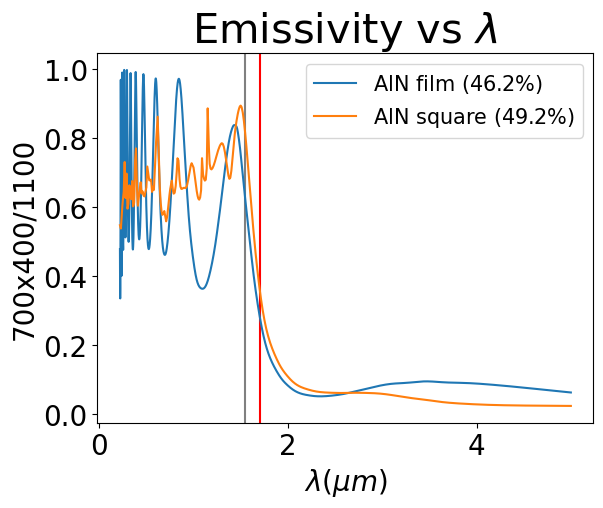

/tmp/ipykernel_6224/1344030595.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  y=torch.load("default-emission.pt")


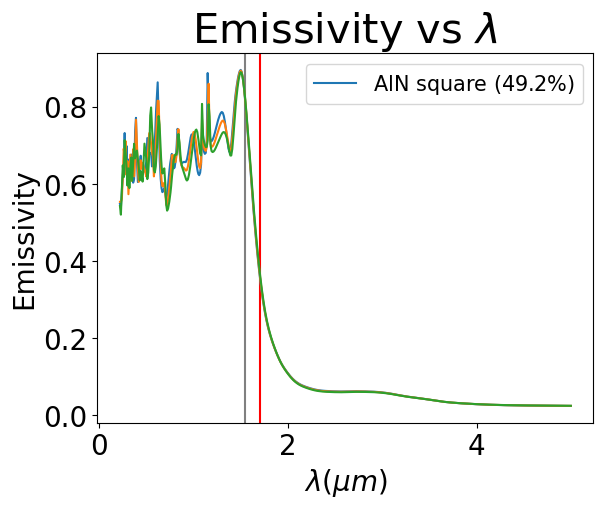

925.24646
1014.2981


In [63]:
import torch;
import ff;
wavelengths=torch.linspace(.22,5,4781);
x=torch.load("0.44_0.7_period1.1_10_long_cut_emission.pt")[:4781];
x1=torch.load("0.44_0.722_period1.1_10_long_cut_emission.pt")[:4781];
x2=torch.load("0.44_0.75_period1.1_10_long_cut_emission.pt")[:4781];
import matplotlib.pyplot as plt;
plt.axvline(1.7,c='r')
plt.axvline(1.55,c='grey')
y=torch.load("default-emission.pt")
plt.title(r"Emissivity vs $\lambda$", fontsize=30)
plt.xlabel(r"$\lambda (\mu m)$",fontsize=20)
plt.ylabel(r'700x400/1100', fontsize=20)
plt.tick_params(labelsize=20)
plt.plot(wavelengths.detach(), y.detach(), label = r'AlN film ($46.2\%$)')
plt.plot(wavelengths.detach(),x.detach(),label = r'AlN square ($49.2\%$)');
# plt.plot(wavelengths.detach(),x1.detach())
# plt.plot(wavelengths.detach(),x2.detach())
plt.legend(fontsize=15)

plt.show()

plt.axvline(1.7,c='r')
plt.axvline(1.55,c='grey')
y=torch.load("default-emission.pt")
plt.title(r"Emissivity vs $\lambda$", fontsize=30)
plt.xlabel(r"$\lambda (\mu m)$",fontsize=20)
plt.ylabel(r'Emissivity', fontsize=20)
plt.tick_params(labelsize=20)
plt.plot(wavelengths.detach(),x.detach(),label = r'AlN square ($49.2\%$)');
plt.plot(wavelengths.detach(),x1.detach())
plt.plot(wavelengths.detach(),x2.detach())
plt.legend(fontsize=15)

plt.show()
import numpy as np
print(np.sum([y.detach()[i] for i in range(1700-220)]))
print(np.sum([x.detach()[i] for i in range(1700-220)]))